In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Data Prepration for LSTM

* In this notebook LSTM is used for forecasting future sales. 
* The type of the LSTM can be regarded as Multivariate and Multiple Input Series (Multi-step is not used).
* The model is trained using past sales values for each 30490 item and a feature which represents if there exists an event at the following day.  
* For this notebook "sales of past 14 days and event feature" are used for predicting 15th day sales. Past days is a parameter which can be set to see the effect. 

* Below timesteps is set to 14 to use past 14 days' sales.
* Since there are lots of zero values in first days, "startDay" parameter can be used ignore unwanted days from the beginning.

In [2]:
# dataPath = "/kaggle/input/m5-forecasting-accuracy/"
dataPath = "../input/m5-forecasting-accuracy/"
timesteps = 28
startDay = 350

In [3]:
dt = pd.read_csv(dataPath + "/sales_train_validation.csv")
dt.head(3)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1


In [4]:
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB
None


In [5]:
#To reduce memory usage
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

In [6]:
#Reduce memory usage and compare with the previous one to be sure
dt = downcast_dtypes(dt)

In [7]:
print(dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int16(1913), object(6)
memory usage: 112.6+ MB
None


* The shape of the data is not exactly what we want.
* We want to have each day as row and 30490 items' sales as columns (features)
* Therefore take the transpose of "dt"

In [8]:
#Take the transpose so that we have one day for each row, and 30490 items' sales as columns
dt = dt.T    
dt.head(8)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
id,HOBBIES_1_001_CA_1_validation,HOBBIES_1_002_CA_1_validation,HOBBIES_1_003_CA_1_validation,HOBBIES_1_004_CA_1_validation,HOBBIES_1_005_CA_1_validation,HOBBIES_1_006_CA_1_validation,HOBBIES_1_007_CA_1_validation,HOBBIES_1_008_CA_1_validation,HOBBIES_1_009_CA_1_validation,HOBBIES_1_010_CA_1_validation,...,FOODS_3_818_WI_3_validation,FOODS_3_819_WI_3_validation,FOODS_3_820_WI_3_validation,FOODS_3_821_WI_3_validation,FOODS_3_822_WI_3_validation,FOODS_3_823_WI_3_validation,FOODS_3_824_WI_3_validation,FOODS_3_825_WI_3_validation,FOODS_3_826_WI_3_validation,FOODS_3_827_WI_3_validation
item_id,HOBBIES_1_001,HOBBIES_1_002,HOBBIES_1_003,HOBBIES_1_004,HOBBIES_1_005,HOBBIES_1_006,HOBBIES_1_007,HOBBIES_1_008,HOBBIES_1_009,HOBBIES_1_010,...,FOODS_3_818,FOODS_3_819,FOODS_3_820,FOODS_3_821,FOODS_3_822,FOODS_3_823,FOODS_3_824,FOODS_3_825,FOODS_3_826,FOODS_3_827
dept_id,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,HOBBIES_1,...,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3,FOODS_3
cat_id,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,HOBBIES,...,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS,FOODS
store_id,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,CA_1,...,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3,WI_3
state_id,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,WI,WI,WI,WI,WI,WI,WI,WI,WI,WI
d_1,0,0,0,0,0,0,0,12,2,0,...,0,14,1,0,4,0,0,0,0,0
d_2,0,0,0,0,0,0,0,15,0,0,...,0,11,1,0,4,0,0,6,0,0


* Remove the first six  colums id, item_id, dept_id, cat_id, store_id, state_id columns, to end up only days as rows

In [9]:
#Remove id, item_id, dept_id, cat_id, store_id, state_id columns
dt = dt[6 + startDay:]
dt.head(5)

,0,1,2,3,4,5,6,7,8,9,...,30480,30481,30482,30483,30484,30485,30486,30487,30488,30489
d_351,0,0,0,2,0,0,0,24,3,2,...,0,9,1,0,11,0,0,1,0,0
d_352,0,0,0,0,0,0,0,9,0,2,...,0,5,4,0,8,0,1,2,0,0
d_353,0,0,0,4,2,0,0,2,1,1,...,0,15,2,0,3,0,1,2,0,0
d_354,0,1,0,2,0,0,0,7,1,0,...,0,5,1,0,3,0,0,0,0,0
d_355,0,0,0,1,2,0,0,0,0,0,...,0,7,1,0,1,0,1,1,0,0


In [10]:
calendar = pd.read_csv(dataPath + "/calendar.csv")


* Here a dataframe is created to store the knowledge if an event exist in the next day
* Firstly, fill with zeros the dataframe

In [11]:
#Create dataframe with zeros for 1969 days in the calendar
daysBeforeEvent = pd.DataFrame(np.zeros((1969,1)))


* Now, "1" is assigned the day before an event exist. Other days will remain as "0".

In [12]:
# "1" is assigned to the days before the event_name_1. Since "event_name_2" is rare, it was not added.
for x,y in calendar.iterrows():
    if((pd.isnull(calendar["event_name_1"][x])) == False):
           daysBeforeEvent[0][x-1] = 1 
            #if first day was an event this row will cause an exception because "x-1".
            #Since it is not i did not consider for now.

   

In [13]:
#"calendar" won't be used anymore. 
del calendar


* Since, the "daysBeforeEvent" feature is used for predicting after the model trained as input, we seperate the 28 days as "daysBeforeEventTest"
* For training the first 1914 days (if "startDay" is zero otherwise "1913-startDay") will be used.

In [14]:
#"daysBeforeEventTest" will be used as input for predicting (We will forecast the days 1913-1941)
daysBeforeEventTest = daysBeforeEvent[1913:1941]
#"daysBeforeEvent" will be used for training as a feature.
daysBeforeEvent = daysBeforeEvent[startDay:1913]



In [15]:
#Before concatanation with our main data "dt", indexes are made same and column name is changed to "oneDayBeforeEvent"
daysBeforeEvent.columns = ["oneDayBeforeEvent"]
daysBeforeEvent.index = dt.index



In [16]:
daysBeforeEvent

,oneDayBeforeEvent
d_351,0.0
d_352,1.0
d_353,0.0
d_354,0.0
d_355,0.0
...,...
d_1909,0.0
d_1910,0.0
d_1911,0.0
d_1912,0.0


* Concatenate "daysBeforeEvent" feature with our main dataframe "dt"

In [17]:
dt = pd.concat([dt, daysBeforeEvent], axis = 1)

dt.columns

Index([                  0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8,
                         9,
       ...
                     30481,               30482,               30483,
                     30484,               30485,               30486,
                     30487,               30488,               30489,
       'oneDayBeforeEvent'],
      dtype='object', length=30491)

In [18]:
#Feature Scaling
#Scale the features using min-max scaler in range 0-1
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
dt_scaled = sc.fit_transform(dt)

In [19]:
timesteps

28

* Here is the important part. "X_train" and "y_train" data is created. For each X_train item, 14 past days' sales and 14 daysBeforeEvent feature are included. So one element of X_train's shape is (14, 30491). For y_train we are predicting one day sales of 30490 items therefore one element of y_train's shape is (1, 30490)

In [20]:
X_train = []
y_train = []
for i in range(timesteps, 1913 - startDay):
    X_train.append(dt_scaled[i-timesteps:i])
    y_train.append(dt_scaled[i][0:30490]) 
    #İmportant!! if extra features are added (like oneDayBeforeEvent) 
    #use only sales values for predictions (we only predict sales) 
    #this is why 0:30490 columns are choosen

Creation of X_train and y_train
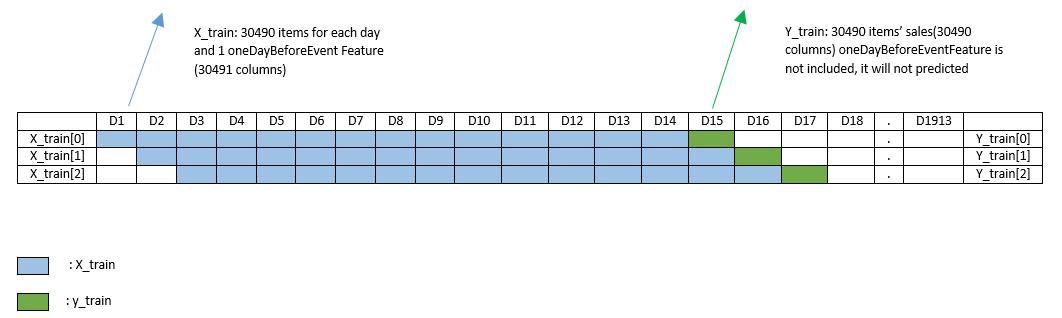

In [21]:
del dt_scaled


In [22]:
#Convert to np array to be able to feed the LSTM model
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1535, 28, 30491)
(1535, 30490)


In [23]:
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [62]:
np.save(f'../cache/baseline-lstm-with-keras-0-7/X_train.npy', X_train) # save
np.save(f'../cache/baseline-lstm-with-keras-0-7/y_train.npy', y_train) # save

In [24]:
# BATCH_SIZE = 64
# EMBEDDING_SIZE = 256
# RNN_SIZE = 512
# NUM_EPOCHS = 15
# input_dims = 30491
# output_dims = 30490
# vocab_size = output_dims
# ATTENTION_FUNC = 'concat'
# # These lines can be used for debugging purpose
# # Or can be seen as a way to build the models
# encoder = Encoder(RNN_SIZE)
# decoder = Decoder(vocab_size, RNN_SIZE, ATTENTION_FUNC)
# initial_state = encoder.init_states(1)
# encoder_outputs = encoder(tf.constant(np.ones(30491, dtype='float32').reshape(1,1,-1)), initial_state)
# decoder_outputs = decoder(tf.constant(np.ones(30491, dtype='float32').reshape(1,1,-1)), encoder_outputs[1:], encoder_outputs[0])

In [25]:
# # def loss_func(targets, logits):
# #     crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# #     mask = tf.math.logical_not(tf.math.equal(targets, 0))
# #     mask = tf.cast(mask, dtype=tf.int64)
# #     loss = crossentropy(targets, logits, sample_weight=mask)
# #     return loss

# def loss_func(targets, logits):
# #     print(targets.shape, logits.shape)
#     mse = tf.keras.losses.mean_squared_error(targets, logits)
#     return mse

# @tf.function
# def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
#     loss = 0
#     with tf.GradientTape() as tape:
#         en_outputs = encoder(source_seq, en_initial_states)
#         en_states = en_outputs[1:]
#         de_state_h, de_state_c = en_states

#         # We need to create a loop to iterate through the target sequences
#         for i in range(target_seq_out.shape[1]):
#             # Input to the decoder must have shape of (batch_size, length)
#             # so we need to expand one dimension
#             decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
#             logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
#             # The loss is now accumulated through the whole batch
#             loss += loss_func(target_seq_out[:, i], logit)

#     variables = encoder.trainable_variables + decoder.trainable_variables
#     gradients = tape.gradient(loss, variables)
#     optimizer.apply_gradients(zip(gradients, variables))

#     return loss / target_seq_out.shape[1]


# def predict(encoder, decoder, X):
    
#     source_seq, target_seq_in = X[0], X[1]
#     en_initial_states = encoder.init_states(1)
#     preds = []
#     for i in np.arange(source_seq.shape[0]):
#         en_outputs = encoder(source_seq[i:i+1], en_initial_states)
#         de_state_h, de_state_c = en_outputs[1:]
#         de_output, de_state_h, de_state_c, alignment = decoder(target_seq_in[i:i+1], (de_state_h, de_state_c), en_outputs[0])
#         preds.append(de_output.numpy())
#     return np.array(preds)

# def train(encoder, decoder, dataset_trn, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE):
    
#     for e in range(num_epochs):
#         en_initial_states = encoder.init_states(batch_size)
# #         encoder.save_weights('../cache/baseline-lstm-with-keras-0-7/encoder_{}.h5'.format(e + 1))
# #         decoder.save_weights('../cache/baseline-lstm-with-keras-0-7/decoder_{}.h5'.format(e + 1))
#         for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset_trn.take(-1)):
#             loss = train_step(source_seq, target_seq_in, target_seq_out, en_initial_states)
#             if batch % 100 == 0:
#                 print(f'Epoch {e + 1} Batch {batch} Loss {np.mean(loss.numpy()):.4f}')
#     return

In [44]:
import tensorflow as tf
import numpy as np


class Encoder(tf.keras.Model):
    def __init__(self, rnn_size, vocab_size=None, embedding_size=None):
        super(Encoder, self).__init__()
        self.rnn_size = rnn_size
        #         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(rnn_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        #         embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm(sequence, initial_state=states)
        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.rnn_size]), tf.zeros([batch_size, self.rnn_size]))


class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size, attention_func):
        super(LuongAttention, self).__init__()
        self.attention_func = attention_func

        if attention_func not in ['dot', 'general', 'concat']:
            raise ValueError('Unknown attention score function! Must be either dot, general or concat.')

        if attention_func == 'general':
            # General score function
            self.wa = tf.keras.layers.Dense(rnn_size)
        elif attention_func == 'concat':
            # Concat score function
            self.wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)

    def call(self, decoder_output, encoder_output):
        if self.attention_func == 'dot':
            # Dot score function: decoder_output (dot) encoder_output
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, encoder_output, transpose_b=True)
        elif self.attention_func == 'general':
            # General score function: decoder_output (dot) (Wa (dot) encoder_output)
            # decoder_output has shape: (batch_size, 1, rnn_size)
            # encoder_output has shape: (batch_size, max_len, rnn_size)
            # => score has shape: (batch_size, 1, max_len)
            score = tf.matmul(decoder_output, self.wa(
                encoder_output), transpose_b=True)
        elif self.attention_func == 'concat':
            # Concat score function: va (dot) tanh(Wa (dot) concat(decoder_output + encoder_output))
            # Decoder output must be broadcasted to encoder output's shape first
            decoder_output = tf.tile(
                decoder_output, [1, encoder_output.shape[1], 1])

            # Concat => Wa => va
            # (batch_size, max_len, 2 * rnn_size) => (batch_size, max_len, rnn_size) => (batch_size, max_len, 1)
            score = self.va(
                self.wa(tf.concat((decoder_output, encoder_output), axis=-1)))

            # Transpose score vector to have the same shape as other two above
            # (batch_size, max_len, 1) => (batch_size, 1, max_len)
            score = tf.transpose(score, [0, 2, 1])

        # alignment a_t = softmax(score)
        alignment = tf.nn.softmax(score, axis=2)

        # context vector c_t is the weighted average sum of encoder output
        context = tf.matmul(alignment, encoder_output)

        return context, alignment


class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, rnn_size, attention_func, embedding_size=None):
        super(Decoder, self).__init__()
        self.attention = LuongAttention(rnn_size, attention_func)
        self.rnn_size = rnn_size
        #         self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(rnn_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        #         embed = self.embedding(sequence)

        # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
        lstm_out, state_h, state_c = self.lstm(sequence, initial_state=state)

        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, rnn_size)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)

        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, rnn_size),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * rnn_size)
        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)

        # lstm_out now has shape (batch_size, rnn_size)
        lstm_out = self.wc(lstm_out)

        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment


class Seq2SeqWithLuong:

    def __init__(self, input_dims, output_dims, rnn_size=512, attention_func='concat'):

        self.input_dims = input_dims
        self.output_dims = output_dims
        self.rnn_size = rnn_size
        self.attention_func = attention_func

        self.encoder = Encoder(rnn_size)
        self.decoder = Decoder(output_dims, rnn_size, attention_func)
        self.optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
        return

    def loss_func(self, targets, logits):
        mse = tf.keras.losses.mean_squared_error(targets, logits)
        return mse

    @tf.function
    def train_step(self, source_seq, target_seq_in, target_seq_out, en_initial_states):
        loss = 0
        with tf.GradientTape() as tape:
            en_outputs = self.encoder(source_seq, en_initial_states)
            en_states = en_outputs[1:]
            de_state_h, de_state_c = en_states
            # We need to create a loop to iterate through the target sequences
            for i in range(target_seq_out.shape[1]):
                # Input to the decoder must have shape of (batch_size, length)
                # so we need to expand one dimension
                decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
                logit, de_state_h, de_state_c, _ = self.decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
                # The loss is now accumulated through the whole batch
                loss += self.loss_func(target_seq_out[:, i], logit)

        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        return loss / target_seq_out.shape[1]

    @tf.function
    def eval_step(self, source_seq, target_seq_in, target_seq_out, en_initial_states):
        loss = 0
        with tf.GradientTape() as tape:
            en_outputs = self.encoder(source_seq, en_initial_states)
            en_states = en_outputs[1:]
            de_state_h, de_state_c = en_states
            # We need to create a loop to iterate through the target sequences
            for i in range(target_seq_out.shape[1]):
                # Input to the decoder must have shape of (batch_size, length)
                # so we need to expand one dimension
                decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
                logit, de_state_h, de_state_c, _ = self.decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
                # The loss is now accumulated through the whole batch
                loss += self.loss_func(target_seq_out[:, i], logit)
        return loss / target_seq_out.shape[1]

    def predict(self, X):
        source_seq, target_seq_in = X, X[:, -1:, :]
        en_initial_states = self.encoder.init_states(1)
        preds = []
        for i in np.arange(source_seq.shape[0]):
            en_outputs = self.encoder(source_seq[i:i + 1], en_initial_states)
            de_state_h, de_state_c = en_outputs[1:]
            de_output, de_state_h, de_state_c, alignment = self.decoder(target_seq_in[i:i + 1],
                                                                        (de_state_h, de_state_c), en_outputs[0])
            preds.append(de_output.numpy())
        return np.array(preds)

    def train(self, X, y, validation_data=None, epochs=10, batch_size=32, verbose=0):
        X1 = X
        X2 = X[:, -1:, :]
        dataset_trn = tf.data.Dataset.from_tensor_slices((X1, X2, y)).shuffle(batch_size)
        dataset_trn = dataset_trn.batch(batch_size, drop_remainder=True)
        his = []
        for e in range(epochs):
            en_initial_states = self.encoder.init_states(batch_size)
            #         encoder.save_weights('../cache/baseline-lstm-with-keras-0-7/encoder_{}.h5'.format(e + 1))
            #         decoder.save_weights('../cache/baseline-lstm-with-keras-0-7/decoder_{}.h5'.format(e + 1))
            trn_loss = 0
            for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset_trn.take(-1)):
                loss = self.train_step(source_seq, target_seq_in, target_seq_out, en_initial_states)
                trn_loss += np.mean(loss.numpy())
                if verbose > 0:
                    if batch % verbose == 0:
                        print(f'Epoch {e + 1} Batch {batch} Loss {np.mean(loss.numpy()):.4f}')
            trn_loss /= batch
            his_i = {'epoch': e + 1, 'loss': trn_loss}

            if not validation_data is None:
                X_val = validation_data[0]
                y_val = validation_data[1]
                X1_val = X_val
                X2_val = X_val[:, -1:, :]
                dataset_val = tf.data.Dataset.from_tensor_slices((X1_val, X2_val, y_val)).shuffle(batch_size)
                dataset_val = dataset_val.batch(batch_size, drop_remainder=True)
                en_initial_states = self.encoder.init_states(batch_size)
                val_loss = 0
                for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(dataset_val.take(-1)):
                    loss = self.eval_step(source_seq, target_seq_in, target_seq_out, en_initial_states)
                    val_loss += np.mean(loss.numpy())
                    # Update val metrics
                    # val_acc_metric.update_state(y_batch_val, val_logits)
                # val_acc = val_acc_metric.result()
                his_i = {**his_i, 'val_loss': val_loss}
            his.append(his_i)
        return his

# LSTM Model with Keras

In [27]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
# from keras.layers import LSTM, Bidirectional,Input
from keras.layers import Dropout
from keras.layers import Input, SimpleRNN, Dense, GRU, LSTM, Reshape, Lambda, Bidirectional
from keras import backend as K
import pickle 
from keras.optimizers import Adam
import numpy as np
from keras.models import Model
from keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt

def plot_train_curve(his, n_col=3):
    N = len(his)
    n_row = N // n_col
    if N % n_col!=0:
        n_row +=1
    fig, axes = plt.subplots(n_row, n_col, figsize=[5*n_col,4*n_row])
    idx = 0
    for ax in axes.flat:
        loss = his[idx]['his']['loss']
        val_loss = his[idx]['his']['val_loss']
        n_loss = len(loss)
        sns.lineplot(x=np.arange(n_loss), y=loss, ax=ax)
        sns.lineplot(x=np.arange(n_loss), y=val_loss, ax=ax)
        ax.set_title(f'fold{idx} last_val_loss{val_loss[-1]:.2} diff{loss[-1]-val_loss[-1]:.2}')
        idx +=1
        if idx == N:
            break
    return

# Initialising the RNN
def build_graph1():

    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=50
    regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=400
    regressor.add(LSTM(units = layer_2_units, return_sequences = True))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=400
    regressor.add(LSTM(units = layer_3_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 30490))

    # Compiling the RNN
    optimizer = Adam(learning_rate=0.001)
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
    
    return regressor

    # Fitting the RNN to the Training set
    
# Initialising the RNN
def build_graph2():

    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=50
    regressor.add(Bidirectional(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2]))))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=400
    regressor.add(Bidirectional(LSTM(units = layer_2_units, return_sequences = True)))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=400
    regressor.add(Bidirectional(LSTM(units = layer_3_units)))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 30490))

    # Compiling the RNN
    optimizer = Adam(learning_rate=0.001)
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
    
    return regressor
    
def build_graph3(input_shape, output_shape,cell_units = 64):
    
    # declare encoder and decoder objects
    encoder = LSTM(units = cell_units, return_state = True)
    decoder = LSTM(units = cell_units, return_sequences=True, return_state = True)
    decoder_dense = Dense(output_shape[-1])

    # data flow
    encoder_input = Input(input_shape)
    encoder_output, state_h, state_c = encoder(encoder_input)
    encoder_state = [state_h, state_c]  

    # initial input and state for iteration
    iter_input = Reshape((1,output_shape[-1]))(decoder_dense(state_h))
    iter_state = encoder_state
    all_output = []
    
    for _ in range(output_shape[0]):
        # Run the decoder on one timestep, output == state_h since only one time step
        output, state_h, state_c = decoder(iter_input, initial_state=iter_state)
        output = decoder_dense(output)

        # Store the current prediction (we will concatenate all predictions later)
        all_output.append(output)

        # Reinject the outputs and state for the next loop iteration
        iter_input = output
        iter_state = [state_h, state_c]
        
    if output_shape[0] == 1:
        decoder_output = all_output[0]
    else:
        # Concatenate all predictions
        decoder_output = tf.keras.layers.Concatenate(axis=1)(all_output)
    model = Model(encoder_input, decoder_output)
    
    # Compiling the RNN
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer = optimizer, loss = 'mean_squared_error')
    return model


# Initialising the RNN
def build_graph4():

    regressor = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=50
    regressor.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    regressor.add(Dropout(0.2))

    # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=400
    regressor.add(LSTM(units = layer_2_units, return_sequences = True, ))
    regressor.add(Dropout(0.2))

    # Adding a third LSTM layer and some Dropout regularisation
    layer_3_units=400
    regressor.add(LSTM(units = layer_3_units))
    regressor.add(Dropout(0.2))

    # Adding the output layer
    regressor.add(Dense(units = 30490))

    # Compiling the RNN
    optimizer = Adam(learning_rate=0.005)
    regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
    
    return regressor

Using TensorFlow backend.


In [192]:
# y_train = np.squeeze(y_train, axis=1)
epoch_no=20
batch_size_RNN=28
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(10)
his = []
for train_index, test_index in tscv.split(X_train):
    regressor = build_graph4()
    his_i = regressor.fit(X_train[train_index], y_train[train_index], epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_train[test_index], y_train[test_index]))
    his.append({'model':regressor, 'his':his_i.history})

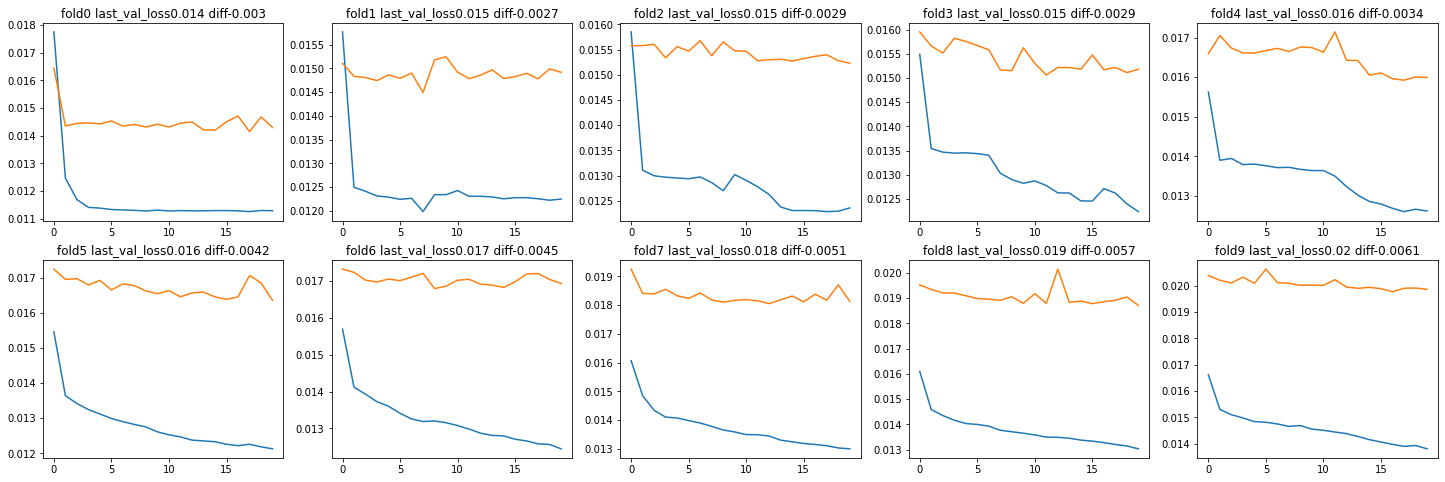

In [44]:
plot_train_curve(his, n_col=5)

In [51]:
# y_train = np.squeeze(y_train, axis=1)
epoch_no=20
batch_size_RNN=28
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(10)
his = []
for train_index, test_index in tscv.split(X_train):
    input_dims = 30491
    output_dims = 30490
    model = Seq2SeqWithLuong(input_dims, output_dims, rnn_size=batch_size_RNN)
    his_i = model.train(X_train[train_index], np.expand_dims(y_train[train_index],1), epochs=epoch_no, batch_size=batch_size_RNN, verbose=0, validation_data=(X_train[test_index], np.expand_dims(y_train[test_index],1)))
    his.append({'model':model, 'his':his_i})
    
for his_i in his:
    df_ = pd.DataFrame(his_i['his'])
    his_i['his'] = {'loss':df_.loss.tolist(), 'val_loss':df_['val_loss'].tolist()}

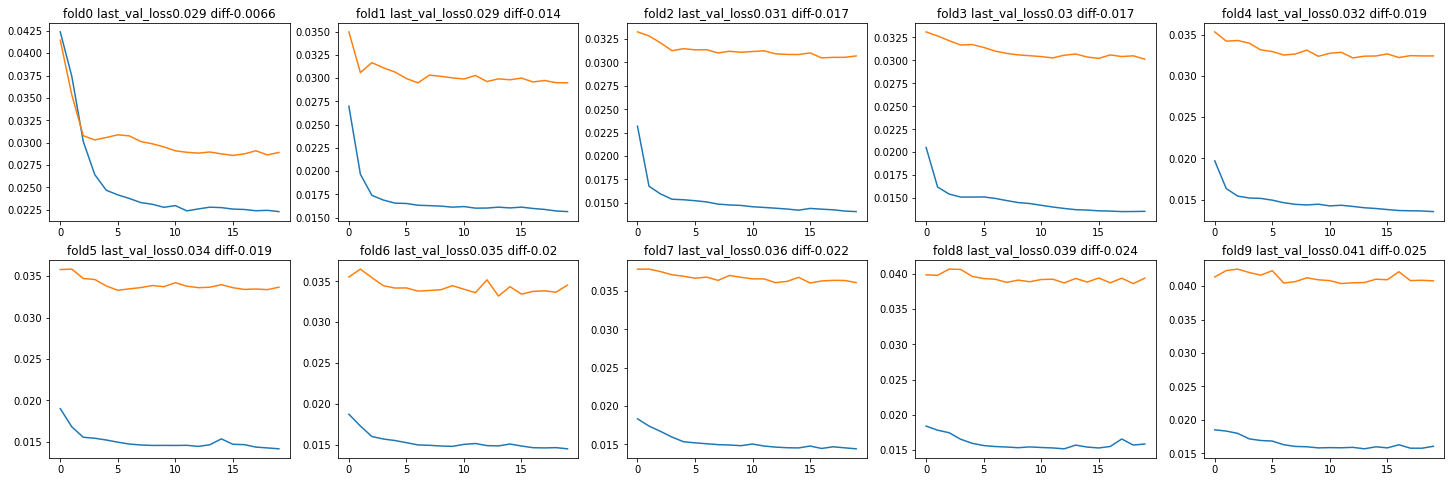

In [52]:
plot_train_curve(his, n_col=5)

In [186]:
# y_train = np.squeeze(y_train, axis=1)
epoch_no=20
batch_size_RNN=14
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(10)
his = []
for train_index, test_index in tscv.split(X_train):
    regressor = build_graph1()
    his_i = regressor.fit(X_train[train_index], y_train[train_index], epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_train[test_index], y_train[test_index]))
    his.append({'model':regressor, 'his':his_i.history})

Train on 145 samples, validate on 139 samples
Epoch 1/20
145/145 [==============================] - 2s 12ms/step - loss: 0.0171 - val_loss: 0.0148
Epoch 2/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0120 - val_loss: 0.0144
Epoch 3/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 4/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0115 - val_loss: 0.0145
Epoch 5/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0114 - val_loss: 0.0143
Epoch 6/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 7/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0112 - val_loss: 0.0141
Epoch 8/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0110 - val_loss: 0.0142
Epoch 9/20
145/145 [==============================] - 1s 8ms/step - loss: 0.0109 - val_loss: 0.0141
Epoch 10/20
145/145 [==============================] 

562/562 [==============================] - 3s 6ms/step - loss: 0.0111 - val_loss: 0.0148
Train on 701 samples, validate on 139 samples
Epoch 1/20
701/701 [==============================] - 5s 7ms/step - loss: 0.0150 - val_loss: 0.0168
Epoch 2/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0132 - val_loss: 0.0162
Epoch 3/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0128 - val_loss: 0.0159
Epoch 4/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0125 - val_loss: 0.0160
Epoch 5/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0123 - val_loss: 0.0159
Epoch 6/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0123 - val_loss: 0.0158
Epoch 7/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0121 - val_loss: 0.0160
Epoch 8/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0120 - val_loss: 0.0159
Epoch 9/20
701/701 [==============================] - 4s 6ms/step

1118/1118 [==============================] - 6s 6ms/step - loss: 0.0120 - val_loss: 0.0180
Epoch 20/20
1118/1118 [==============================] - 6s 6ms/step - loss: 0.0120 - val_loss: 0.0178
Train on 1257 samples, validate on 139 samples
Epoch 1/20
1257/1257 [==============================] - 8s 6ms/step - loss: 0.0158 - val_loss: 0.0195
Epoch 2/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0143 - val_loss: 0.0191
Epoch 3/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0140 - val_loss: 0.0190
Epoch 4/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0137 - val_loss: 0.0188
Epoch 5/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0135 - val_loss: 0.0188
Epoch 6/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0134 - val_loss: 0.0188
Epoch 7/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0133 - val_loss: 0.0187
Epoch 8/20
1257/1257 [=======================

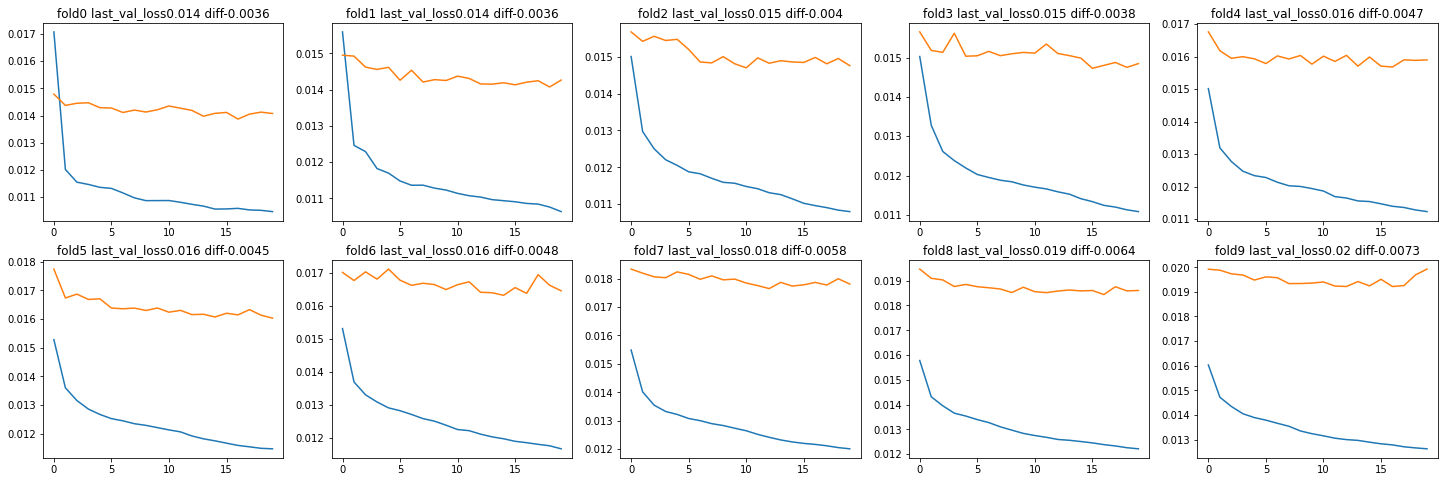

In [188]:
plot_train_curve(his, n_col=5)

In [27]:
# y_train = np.squeeze(y_train, axis=1)
epoch_no=20
batch_size_RNN=14
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(10)
his = []
for train_index, test_index in tscv.split(X_train):
    regressor = build_graph2()
    his_i = regressor.fit(X_train[train_index], y_train[train_index], epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_train[test_index], y_train[test_index]))
    his.append({'model':regressor, 'his':his_i.history})

Train on 145 samples, validate on 139 samples
Epoch 1/20
145/145 [==============================] - 4s 26ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 2/20
145/145 [==============================] - 3s 17ms/step - loss: 0.0119 - val_loss: 0.0143
Epoch 3/20
145/145 [==============================] - 3s 18ms/step - loss: 0.0115 - val_loss: 0.0143
Epoch 4/20
145/145 [==============================] - 3s 18ms/step - loss: 0.0113 - val_loss: 0.0146
Epoch 5/20
145/145 [==============================] - 3s 18ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 6/20
145/145 [==============================] - 3s 17ms/step - loss: 0.0110 - val_loss: 0.0145
Epoch 7/20
145/145 [==============================] - 3s 18ms/step - loss: 0.0109 - val_loss: 0.0141
Epoch 8/20
145/145 [==============================] - 3s 18ms/step - loss: 0.0107 - val_loss: 0.0147
Epoch 9/20
145/145 [==============================] - 3s 18ms/step - loss: 0.0107 - val_loss: 0.0141
Epoch 10/20
145/145 [========================

Epoch 20/20
562/562 [==============================] - 7s 13ms/step - loss: 0.0105 - val_loss: 0.0148
Train on 701 samples, validate on 139 samples
Epoch 1/20
701/701 [==============================] - 10s 15ms/step - loss: 0.0148 - val_loss: 0.0162
Epoch 2/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0129 - val_loss: 0.0160
Epoch 3/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0125 - val_loss: 0.0165
Epoch 4/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0123 - val_loss: 0.0158
Epoch 5/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0120 - val_loss: 0.0160
Epoch 6/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0118 - val_loss: 0.0157
Epoch 7/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0117 - val_loss: 0.0158
Epoch 8/20
701/701 [==============================] - 9s 13ms/step - loss: 0.0116 - val_loss: 0.0157
Epoch 9/20
701/701 [=======================

Epoch 18/20
1118/1118 [==============================] - 14s 12ms/step - loss: 0.0116 - val_loss: 0.0181
Epoch 19/20
1118/1118 [==============================] - 14s 12ms/step - loss: 0.0115 - val_loss: 0.0179
Epoch 20/20
1118/1118 [==============================] - 14s 12ms/step - loss: 0.0115 - val_loss: 0.0179
Train on 1257 samples, validate on 139 samples
Epoch 1/20
1257/1257 [==============================] - 17s 13ms/step - loss: 0.0155 - val_loss: 0.0191
Epoch 2/20
1257/1257 [==============================] - 15s 12ms/step - loss: 0.0140 - val_loss: 0.0188
Epoch 3/20
1257/1257 [==============================] - 15s 12ms/step - loss: 0.0135 - val_loss: 0.0187
Epoch 4/20
1257/1257 [==============================] - 15s 12ms/step - loss: 0.0132 - val_loss: 0.0185
Epoch 5/20
1257/1257 [==============================] - 15s 12ms/step - loss: 0.0130 - val_loss: 0.0184
Epoch 6/20
1257/1257 [==============================] - 15s 12ms/step - loss: 0.0129 - val_loss: 0.0184
Epoch 7/20
125

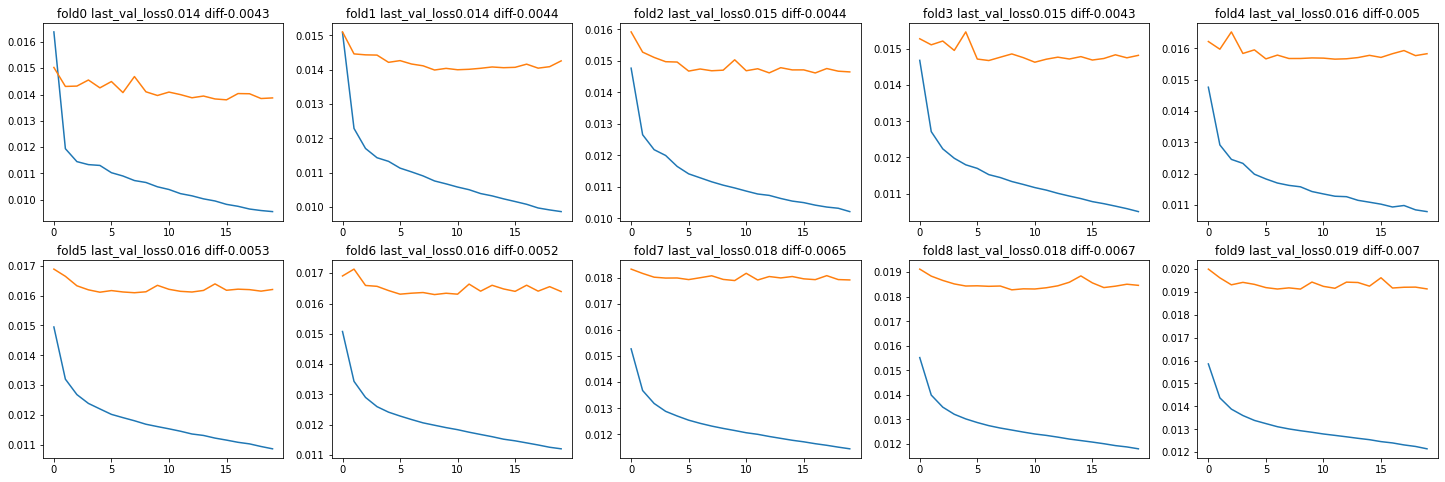

In [29]:
plot_train_curve(his, n_col=5)

In [25]:
epoch_no=20
batch_size_RNN=28
his = []
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5)
# for train_index, test_index in kf.split(X_train, y_train):
#     regressor = build_graph()
#     his_i = regressor.fit(X_train[train_index], y_train[train_index], epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_train[test_index], y_train[test_index]))
#     his.append({'model':regressor})

# regressor = build_graph()
# his_i = regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN)
# his.append({'model':regressor})

from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(10)
y_train = np.expand_dims(y_train,1)
for train_index, test_index in tscv.split(X_train):
    regressor = build_graph3(input_shape=(X_train.shape[1], X_train.shape[2]), output_shape=(y_train.shape[1], y_train.shape[2]))
    his_i = regressor.fit(X_train[train_index], y_train[train_index], epochs = epoch_no, batch_size = batch_size_RNN, validation_data=(X_train[test_index], y_train[test_index]))
    his.append({'model':regressor, 'his':his_i.history})
y_train = np.squeeze(y_train,1)

his = []
y_train = np.expand_dims(y_train,1)
regressor = build_graph3(input_shape=(X_train.shape[1], X_train.shape[2]), output_shape=(y_train.shape[1], y_train.shape[2]))
his_i = regressor.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size_RNN, )
his.append({'model':regressor, 'his':his_i.history})
y_train = np.squeeze(y_train,1)

Train on 145 samples, validate on 139 samples
Epoch 1/20
145/145 [==============================] - 2s 14ms/step - loss: 0.0199 - val_loss: 0.0183
Epoch 2/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0141 - val_loss: 0.0155
Epoch 3/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0120 - val_loss: 0.0148
Epoch 4/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0116 - val_loss: 0.0147
Epoch 5/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 6/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 7/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0113 - val_loss: 0.0144
Epoch 8/20
145/145 [==============================] - 1s 9ms/step - loss: 0.0113 - val_loss: 0.0145
Epoch 9/20
145/145 [==============================] - 1s 10ms/step - loss: 0.0113 - val_loss: 0.0143
Epoch 10/20
145/145 [=========================

562/562 [==============================] - 4s 6ms/step - loss: 0.0112 - val_loss: 0.0149
Train on 701 samples, validate on 139 samples
Epoch 1/20
701/701 [==============================] - 5s 7ms/step - loss: 0.0162 - val_loss: 0.0169
Epoch 2/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0138 - val_loss: 0.0167
Epoch 3/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0136 - val_loss: 0.0164
Epoch 4/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0130 - val_loss: 0.0160
Epoch 5/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0126 - val_loss: 0.0162
Epoch 6/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0124 - val_loss: 0.0158
Epoch 7/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0121 - val_loss: 0.0165
Epoch 8/20
701/701 [==============================] - 4s 6ms/step - loss: 0.0120 - val_loss: 0.0160
Epoch 9/20
701/701 [==============================] - 4s 6ms/step

1118/1118 [==============================] - 6s 6ms/step - loss: 0.0120 - val_loss: 0.0178
Epoch 20/20
1118/1118 [==============================] - 7s 6ms/step - loss: 0.0120 - val_loss: 0.0177
Train on 1257 samples, validate on 139 samples
Epoch 1/20
1257/1257 [==============================] - 8s 6ms/step - loss: 0.0166 - val_loss: 0.0202
Epoch 2/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0147 - val_loss: 0.0194
Epoch 3/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0142 - val_loss: 0.0189
Epoch 4/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0139 - val_loss: 0.0188
Epoch 5/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0135 - val_loss: 0.0188
Epoch 6/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0132 - val_loss: 0.0186
Epoch 7/20
1257/1257 [==============================] - 7s 6ms/step - loss: 0.0131 - val_loss: 0.0186
Epoch 8/20
1257/1257 [=======================

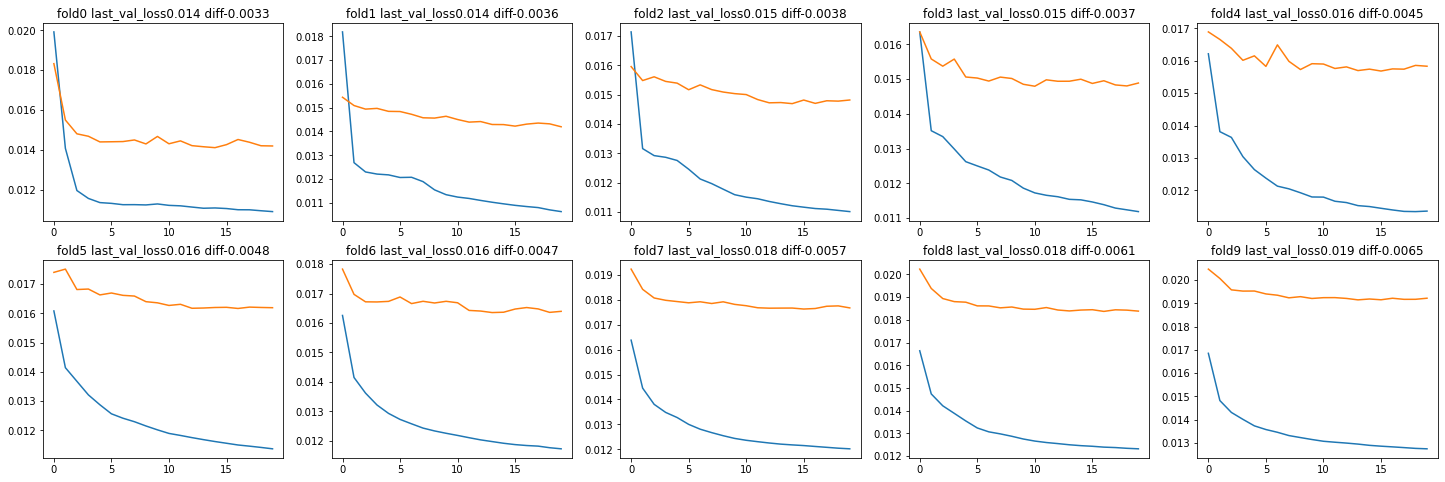

In [26]:
plot_train_curve(his, n_col=5)

* Take last days, 14 for this notebook ("timestep" parameter) in order to predict firts unknown day's sales.
* Before using values for prediction, again use min-max transformation

In [46]:
inputs= dt[-timesteps:]
inputs = sc.transform(inputs)

* Here is again an important part. 
* We are using last 14 days in order to predict day 1915 sales.
* In order to predict 1916th day, 13 days from our input data and 1 day from our prediction are used. After that we slide the window one by one.
    * 12 days from input data + 2 days from our prediction to predict 1917th day
    * 11 days from input data + 3 days from our prediction to predict 1918th day
    * .....
    * 14 days our prediction to predict last 1941th day sales.

In [47]:
# X_test = []
# X_test.append(inputs[0:timesteps])
# X_test = np.array(X_test)
# predictions = []

# for j in range(timesteps,timesteps + 28):
#     X_i = X_test[0,j - timesteps:j].reshape(1, timesteps, 30491)
#     X_i = X_i.astype('float32')
#     predicted_stock_price = model.predict([X_i, X_i[:,-1:,:]])
#     predicted_stock_price = np.squeeze(predicted_stock_price, axis=1)
#     testInput = np.column_stack((np.array(predicted_stock_price), daysBeforeEventTest[0][1913 + j - timesteps]))
#     X_test = np.append(X_test, testInput).reshape(1,j + 1,30491)
#     predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
#     predictions.append(predicted_stock_price)

In [48]:
X_test = []
X_test.append(inputs[0:timesteps])
X_test = np.array(X_test)
predictions = []

for j in range(timesteps,timesteps + 28):
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = 0
    for item in his[-1:]:
        model = item['model']
        predicted_stock_price += model.predict(X_test[0,j - timesteps:j].reshape(1, timesteps, 30491))
        predicted_stock_price = np.squeeze(predicted_stock_price, axis=1)
    predicted_stock_price /= len(his[-1:])
    testInput = np.column_stack((np.array(predicted_stock_price), daysBeforeEventTest[0][1913 + j - timesteps]))
    X_test = np.append(X_test, testInput).reshape(1,j + 1,30491)
    predicted_stock_price = sc.inverse_transform(testInput)[:,0:30490]
    predictions.append(predicted_stock_price)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



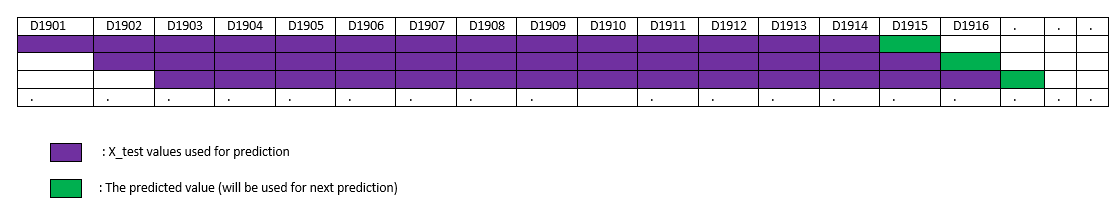

# Submission File Creation
* Here, the submission file creation is done.

In [169]:
ori_submission =  pd.read_csv("../cache/submission/lstm-keras-0o7submission.csv")

In [175]:
for i in range(1,29):
    col = f'F{i}'
    print(col, ori_submission[col][:30490].sum())

F1 39008.10222554451
F2 35077.456563211046
F3 32970.6698775831
F4 33612.69815234313
F5 38749.42370956589
F6 47699.885071658995
F7 51678.08678477607
F8 39778.075671222934
F9 35716.64891673002
F10 34232.368490819994
F11 35469.62726189877
F12 40899.02951197239
F13 50433.46037289311
F14 54968.06636921514
F15 41506.33536986407
F16 37602.06392187736
F17 36272.918552122515
F18 37339.54164605419
F19 41545.38219872455
F20 50619.96089796684
F21 54806.68732636038
F22 41548.34596519446
F23 37782.246990157815
F24 36293.74776266783
F25 37076.81218691362
F26 40833.58272139932
F27 48904.522385204946
F28 52962.50590197416


In [49]:
import time

submission = pd.DataFrame(data=np.array(predictions).reshape(28,30490))

submission = submission.T
    
submission = pd.concat((submission, submission), ignore_index=True)

sample_submission = pd.read_csv(dataPath + "/sample_submission.csv")
    
idColumn = sample_submission[["id"]]
    
submission[["id"]] = idColumn  

cols = list(submission.columns)
cols = cols[-1:] + cols[:-1]
submission = submission[cols]

colsdeneme = ["id"] + [f"F{i}" for i in range (1,29)]

submission.columns = colsdeneme

currentDateTime = time.strftime("%d%m%Y_%H%M%S")

submission.to_csv("../cache/submission/lstm-keras-0o7submission_seq2seqAttendtion_10.csv", index=False)

In [50]:
for i in range(1,29):
    col = f'F{i}'
    print(col, submission[col][:30490].sum())

F1 33191.15877834387
F2 33191.15164670834
F3 33191.15116534056
F4 33191.151044878396
F5 33191.151044878396
F6 33191.15053707421
F7 33191.15053707421
F8 33191.15080014686
F9 33191.15084431096
F10 33191.15052078929
F11 33191.14978303046
F12 33191.14945726855
F13 33191.14945726855
F14 33191.14984536341
F15 33191.15008126084
F16 33191.15048411676
F17 33191.150437497665
F18 33191.150437497665
F19 33191.15108327581
F20 33191.15101719415
F21 33191.1507182339
F22 33191.15034773783
F23 33191.150427437926
F24 33191.151176950385
F25 33191.151176950385
F26 33191.15103227513
F27 33191.150979881015
F28 33191.15089350946


# Future Improvements
* Here only sales of past days and oneDayBeforeEvent feature are used for prediction. More feature can be added.
    * Maybe, lag features, sell prices can be included. But including those features for each item can increase the column size from 30491 to 60981 maybe more. Any ideas for feature addition are very welcome. I could not find a proper way to add those kind of features.
* Data preprocessing may be applied. There are lots of zero values especially in the first year. But I could not find a way how to deal with them. In addition, outliers can be handled if any, especially if sell prices data is used.
* Multi-step LSTM can be used for prediction of more than one day (for example 28 days at once or 14 days, 7 days, 2 days etc.)
* Choosing correct neuron sizes, batch size and layer size can be achieved.
* Each run can create different results. I did not add seed value but may be this can be added. I have wanted to see how much the result differs
* You can share any ideas for improvement as a comment, we can discuss more detail

In [65]:
sales_train_evaluation_df = pd.read_csv('../input/m5-forecasting-accuracy2/sales_train_evaluation.csv')

In [66]:
sales_train_evaluation_df[['id']+[f'd_{i}' for i in range(1914,1914+28)]]

,id,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,0,0,0,2,0,3,5,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,0,1,0,0,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,0,0,1,1,0,2,1,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,0,0,1,2,4,1,6,4,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,1,0,2,3,1,0,3,2,3,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,0,0,0,2,2,0,0,0,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,0,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,0,0,1,1,0,2,1,1,0,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,1,3,0,1,2,1,0,2,1,...,1,1,1,4,6,0,1,1,1,0


In [76]:
index_columns = ['id']
grid_1941 = pd.melt(sales_train_evaluation_df[['id']+[f'd_{i}' for i in range(1914,1914+28)]],
                      id_vars=index_columns,
                      var_name='d',
                      value_name='sales')
grid_1941['d'] = grid_1941['d'].apply(lambda x: int(x[2:]))

In [77]:
grid_1941.sort_values(by=['id', 'd'], inplace=True)

In [84]:
grid_1941.head()

,id,d,sales
1612,FOODS_1_001_CA_1_evaluation,1914,2
32102,FOODS_1_001_CA_1_evaluation,1915,0
62592,FOODS_1_001_CA_1_evaluation,1916,0
93082,FOODS_1_001_CA_1_evaluation,1917,0
123572,FOODS_1_001_CA_1_evaluation,1918,0


In [63]:
sub1 = pd.read_csv('../cache/submission/lstm-keras-0o7submission.csv')

In [67]:
sub1.iloc[:30490]

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,1.038213,1.040089,0.954342,0.904251,0.932615,1.034645,0.903294,0.984225,1.033246,...,0.903819,1.028551,0.916069,0.990183,1.042966,1.003209,0.963373,0.938937,1.053327,0.959418
1,HOBBIES_1_002_CA_1_validation,0.175252,0.228181,0.241419,0.264423,0.336867,0.427482,0.311044,0.172539,0.223173,...,0.225093,0.279552,0.162124,0.117127,0.164646,0.178226,0.196583,0.247342,0.318683,0.189185
2,HOBBIES_1_003_CA_1_validation,0.460226,0.437654,0.385550,0.368439,0.466771,0.707331,0.641864,0.402258,0.398393,...,0.504777,0.767518,0.677489,0.468313,0.472598,0.451986,0.454236,0.544144,0.797518,0.729412
3,HOBBIES_1_004_CA_1_validation,1.908242,1.317212,1.264429,1.516104,1.982438,2.674323,3.952093,1.891081,1.165621,...,1.762770,2.612146,4.024041,1.738898,1.187971,1.166770,1.426311,1.873574,2.754219,4.170269
4,HOBBIES_1_005_CA_1_validation,1.006457,1.025911,1.059167,1.069757,1.101654,1.349991,1.602977,1.016160,0.989679,...,1.087496,1.440880,1.772200,1.006266,0.991923,1.044716,1.083760,1.114422,1.387057,1.680708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0.137738,0.069299,0.079993,0.159462,0.247206,0.217640,0.309252,0.177801,0.117864,...,0.233185,0.151819,0.346543,0.267278,0.192098,0.180996,0.215415,0.207936,0.139141,0.288358
30486,FOODS_3_824_WI_3_validation,0.165430,0.135920,0.076607,0.000358,-0.003545,0.169409,0.340450,0.191491,0.147153,...,0.137583,0.300624,0.476458,0.368355,0.315344,0.253372,0.162383,0.122333,0.227928,0.374788
30487,FOODS_3_825_WI_3_validation,0.778630,0.698345,0.504203,0.340080,0.348460,0.510352,0.605119,0.766264,0.752958,...,0.879395,1.075803,1.279009,1.365534,1.289278,1.093475,0.905206,0.845093,0.946264,1.080552
30488,FOODS_3_826_WI_3_validation,1.060100,0.917848,0.820611,0.743772,0.724253,0.948374,1.450852,1.152574,0.967303,...,0.731586,0.914104,1.396226,1.063318,0.912517,0.810835,0.719946,0.676312,0.821098,1.290336


In [125]:
index_columns = ['id']
grid_lstm = pd.melt(sub1.iloc[:30490],
                      id_vars=index_columns,
                      var_name='d',
                      value_name='sales')
grid_lstm['d'] = grid_lstm['d'].apply(lambda x: int(x[1:])+1913)
grid_lstm['id'] = grid_lstm['id'].apply(lambda x: x[:-11])
grid_lstm.sort_values(by=['id', 'd'], inplace=True)

In [126]:
sub2 = pd.read_csv('../cache/submission/lgbm_baseline_submission_groupbymonth_amd.csv')
index_columns = ['id']
grid_lgbm = pd.melt(sub2.iloc[:30490],
                      id_vars=index_columns,
                      var_name='d',
                      value_name='sales')
grid_lgbm['d'] = grid_lgbm['d'].apply(lambda x: int(x[1:])+1913)
grid_lgbm['id'] = grid_lgbm['id'].apply(lambda x: x[:-11])
grid_lgbm.sort_values(by=['id', 'd'], inplace=True)

In [83]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

In [94]:
rmse(grid_1941[grid_1941['d']>1914].sales.values, grid_sub_lstm[grid_sub_lstm['d']>1914].sales.values)

2.1095530560247027

In [95]:
rmse(grid_1941[grid_1941['d']>1914].sales.values, grid_lgbm[grid_lgbm['d']>1914].sales.values)

2.2820489558064123

In [130]:
import numpy as np


def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [120]:
grid = pd.melt(sales_train_evaluation_df.drop(columns=['item_id','dept_id','cat_id','state_id','store_id']),
                      id_vars=['id'],
                      var_name='d',
                      value_name='sales')
grid['d'] = grid['d'].apply(lambda x: int(x[2:]))
grid['id'] = grid['id'].apply(lambda x: x[:-11])

In [128]:
from tqdm import tqdm

In [131]:
lst = []
grid_groupby_id = grid.groupby('id')
for id_, group in tqdm(grid_groupby_id):
    training_series = group[group['d']<=1913]['sales'].values
    testing_series = group[group['d']>1913]['sales'].values
    prediction_series_lstm = grid_lstm[grid_lstm['id']==id_]['sales'].values
    prediction_series_lgbm = grid_lgbm[grid_lgbm['id']==id_]['sales'].values
    mase_lstm = MASE(np.trim_zeros(training_series, 'f'), testing_series, prediction_series_lstm)
    mase_lgbm = MASE(np.trim_zeros(training_series, 'f'), testing_series, prediction_series_lgbm)
    lst.append({'id':id_, 'mase_lstm':mase_lstm, 'mase_lgbm':mase_lgbm})

100%|██████████| 30490/30490 [49:58<00:00, 10.17it/s]


In [139]:
score_df = pd.DataFrame(lst)
score_df['id'] = list(grid_groupby_id.groups.keys())

In [141]:
score_df.mase_lstm.mean()

1.0647599396791432

In [142]:
score_df.mase_lgbm.mean()

1.0802580636711592

In [143]:
score_df

,mase_lstm,mase_lgbm,id
0,1.085195,0.799273,FOODS_1_001_CA_1
1,0.588384,0.686498,FOODS_1_001_CA_2
2,0.634441,0.586846,FOODS_1_001_CA_3
3,0.741294,0.789656,FOODS_1_001_CA_4
4,0.991226,0.874608,FOODS_1_001_TX_1
...,...,...,...
30485,0.974056,0.862798,HOUSEHOLD_2_516_TX_2
30486,2.076180,2.107272,HOUSEHOLD_2_516_TX_3
30487,1.366968,1.573581,HOUSEHOLD_2_516_WI_1
30488,1.842581,1.752568,HOUSEHOLD_2_516_WI_2
